In [1]:
import os
import glob
import yaml
import numpy as np
import xarray as xr
import dask
import cftime
import nc_time_axis
import subprocess
import matplotlib.pyplot as plt
import osprey_eof as ose
import osprey_actions as osa
import osprey_io as osi
import osprey_tools as ost

In [2]:
expname='lfr0'
var='thetao'
ndim='3D'
endleg=21 
yearspan=10
yearleap=10

In [3]:
endyear = ost.get_year(endleg)
startleg = ost.get_startleg(endleg, yearspan)
startyear = ost.get_startyear(endyear, yearspan)
foreyear = ost.get_forecast_year(endyear,yearleap)
fdate = cftime.DatetimeGregorian(foreyear, 1, 1, 12, 0, 0, has_year_zero=False)
xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})
data = osi.read_T(expname, startyear, endyear)

In [4]:
data

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 108, z: 31, y: 148, x: 180)
Coordinates:
    lat          (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lon          (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z            (z) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
  * time         (time) object 864B 2000-01-16 12:00:00 ... 2008-12-16 12:00:00
Dimensions without coordinates: y, x
Data variables: (12/22)
    e3t          (time, z, y, x) float32 357MB dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    thetao       (time, z, y, x) float32 357MB dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    so           (time, z, y, x) float32 357MB dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    tos          (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    sos          (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    zos          (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    ...           ...
    qt_oce       (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    sfx          (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    taum         (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    windsp       (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    precip       (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    snowpre      (time, y, x) float32 12MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
Attributes:
    name:         output/nemo/lfr0_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-12 17:01:17 GMT
    uuid:         ec58c139-1564-4649-a6bb-40f5e29a95cf

In [5]:
p = data[var].polyfit(dim='time', deg=1, skipna=True)
yf = xr.polyval(xf, p.polyfit_coefficients)

In [6]:
yf

<xarray.DataArray (time: 1, z: 31, y: 148, x: 180)> Size: 7MB
dask.array<add, shape=(1, 31, 148, 180), dtype=float64, chunksize=(1, 31, 148, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8B 2019-01-01 12:00:00
  * z        (z) float32 124B 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
  * y        (y) int64 1kB 0 1 2 3 4 5 6 7 8 ... 140 141 142 143 144 145 146 147
  * x        (x) int64 1kB 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179

In [7]:
yf = yf.rename({'time': 'time_counter', 'z': 'nav_lev'})
yf = yf.drop_indexes({'x', 'y'})
yf = yf.reset_coords({'x', 'y'}, drop=True)

In [8]:
yf

<xarray.DataArray (time_counter: 1, nav_lev: 31, y: 148, x: 180)> Size: 7MB
dask.array<add, shape=(1, 31, 148, 180), dtype=float64, chunksize=(1, 31, 148, 180), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) object 8B 2019-01-01 12:00:00
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
Dimensions without coordinates: y, x

In [13]:
rdata = osi.read_rebuilt(expname, endleg, endleg)
varlist = ['tn', 'tb']
for var1 in varlist:
    rdata[var1] = xr.where(rdata[var1] !=0, yf.values, 0.0)

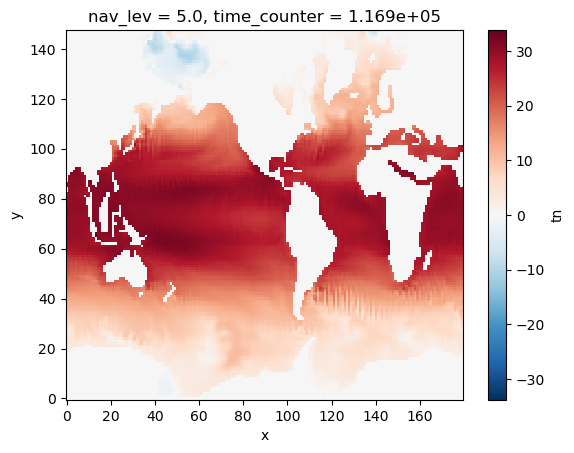

In [14]:
rdata['tn'].isel(time_counter=0,nav_lev=0).plot()